# 네이버 뉴스 카테고리 분류기 만들기

## 자연어처리 라이브러리 설치

In [ ]:
# Install konlpy verbose.
!curl -sv https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [1]:
from konlpy.tag import Okt
import tqdm
from matplotlib import pyplot as plt
import re
import pickle

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

from pathlib import Path

from google.colab import drive
drive.mount('/content/drive') # 원하는 세부 경로로 변경이 불가능합니다.

Mounted at /content/drive


## 데이터셋 불러오기

In [ ]:
data_dir = '/content/drive/MyDrive/data'

p = Path(data_dir)
csv_list = list(p.glob('*.csv'))


In [ ]:

news_df = pd.DataFrame()
for csv in csv_list:
    df_data = pd.read_csv(csv)
    news_df = pd.concat([news_df, df_data])

print('전체 리뷰 수:', len(news_df))
news_df = news_df[['category', 'document']]
news_df.head()

전체 리뷰 수: 2757


,category,document
0,사회,"통계청, 9월 인구동향…작년 3분기比 0.1명↓47개월째 인구 자연감소(세종=연합뉴..."
1,경제,통계청 인구동향17개 광역시·도 일제히 하락광주 0.2명 줄어 하락폭 최대 인구 4...
2,사회,1년 전보다 0.1명 줄어들어 0.7명9월 출생아 수·혼인도 가장 낮아다문화 혼인은...
3,경제,3분기 합계출산율 0.7명 기록3분기 기준 역대 최저치4분기에는 더 떨어질 가능성 ...
4,경제,"[앵커]출산율 감소, 혼인율 감소 저도 계속 전하는 입장에서 뾰족한 대책이 없..."


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2757 entries, 0 to 278
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2757 non-null   object
 1   document  2748 non-null   object
dtypes: object(2)
memory usage: 64.6+ KB


In [ ]:
news_df['category'].value_counts()

경제      1060
사회       786
생활       337
세계       215
IT       188
오피니언      81
정치        81
Name: category, dtype: int64

In [ ]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

le = LabelEncoder()
categories = news_df['category'].tolist()
le.fit(categories)
news_df['category'] = le.transform(categories)

In [ ]:
news_df[:5]

,category,document
0,2,"통계청, 9월 인구동향…작년 3분기比 0.1명↓47개월째 인구 자연감소(세종=연합뉴..."
1,1,통계청 인구동향17개 광역시·도 일제히 하락광주 0.2명 줄어 하락폭 최대 인구 4...
2,2,1년 전보다 0.1명 줄어들어 0.7명9월 출생아 수·혼인도 가장 낮아다문화 혼인은...
3,1,3분기 합계출산율 0.7명 기록3분기 기준 역대 최저치4분기에는 더 떨어질 가능성 ...
4,1,"[앵커]출산율 감소, 혼인율 감소 저도 계속 전하는 입장에서 뾰족한 대책이 없..."


In [ ]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ",news_df['document'].nunique()," 라벨 : ",news_df['category'].nunique())

# 중복 데이터 제거
news_df.drop_duplicates(subset=['document'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 데이터셋 : {}'.format(len(news_df)))


학습데이터 :  2288  라벨 :  7
중복 제거 후 데이터셋 : 2289


In [ ]:
# null 데이터 제거
news_df['document'].replace('', np.nan, inplace=True)
news_df = news_df.dropna(how = 'any')

print('null 제거 후 데이터셋 : {}'.format(len(news_df)))


null 제거 후 데이터셋 : 2288


In [ ]:
print(news_df['category'][0])
print(news_df['document'][0])


0    2
0    2
0    1
0    0
0    2
0    1
0    1
Name: category, dtype: int64
0    통계청, 9월 인구동향…작년 3분기比 0.1명↓47개월째 인구 자연감소(세종=연합뉴...
0    정부-의협, 19차 의료현안협의체…의협 강경자세 표명 후 첫 회의의협, 정부 수요조...
0    박춘섭 신임 경제수석한은 금통위원 이임식 후 기자들과 만나"부동산 PF, 대출 연체...
0    [앵커]미국의 오픈AI가 생성형 인공지능 챗GPT를 내놓은 지 꼭 1년이 됐습니다....
0    아침 기온 -10~3도…낮 기온 5~11도[서울=뉴시스] 정병혁 기자 = 연일 영하...
0    후티반군 잇단 선박 공격으로수에즈 운하 막혀 남아공 우회홍해에서 작전 중인 미 해군...
0    미아동 꿈의숲롯데캐슬 11.7억→7억"상반기까지 바닥권 거래량 지속 예상"[서울=뉴...
Name: document, dtype: object


학습 문장 최대 길이 : 21388
학습 문장의 평균 길이 : 1494.8907342657342


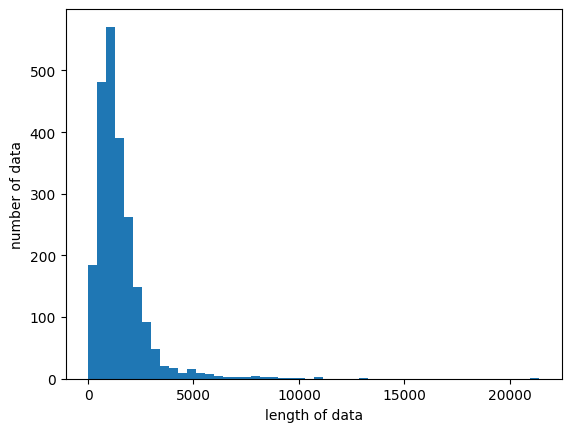

In [ ]:

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in news_df['document']))
print('학습 문장의 평균 길이 :',sum(map(len, news_df['document']))/len(news_df['document']))

plt.hist([len(s) for s in news_df['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [ ]:

# save
with open('data.pickle', 'wb') as f:
    pickle.dump(news_df, f, pickle.HIGHEST_PROTOCOL)

피클로 저장하고 종료

In [20]:
with open("/content/drive/MyDrive/data/data.pickle","rb") as fr:
    news_df = pickle.load(fr)

너무 긴 문장들은 삭제

In [21]:
news_df_df = news_df[news_df.apply(lambda row: len(row['document']) <= 5000, axis=1)]
len(news_df)

2288

## 형태소 분석

In [22]:


def tokenize_and_stemming(sentence, tokenizer):

    sentence = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", sentence)

    raw_pos_tagged = tokenizer.pos(sentence, stem=True) # POS Tagging with stemming

    sentence_tokenized = []
    for token, pos in raw_pos_tagged: # ex) word <- ('서울', 'Noun')
        # pos 기준 제거 대상 : ["Josa", "Eomi", "Punctuation", "Foreign", "Number", "Suffix", "Determiner"]
        # 리뷰 텍스트 상 형태소의 순서를 고려하는 경우 의미를 갖게 됨 : "VerbPrefix" (잘/안/못), "Conjunction"(하지만/그러나/그리고), "KoreanParticle"(ㅋㅋㅋ/ㅎㅎㅎ/ㅠㅠ)
        if (len(token) != 1) & (pos in ["Noun", "VerbPrefix", "Verb", "Adverb", "Adjective", "Conjunction", "KoreanParticle"]):
            sentence_tokenized.append(token)

    return sentence_tokenized

In [23]:

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
tokenized_sentences = []

for sentence in tqdm.tqdm(news_df['document']):
    try:
        tokenized_sentence = tokenize_and_stemming(sentence, okt)
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        rejoined_sentence = ' '.join(stopwords_removed_sentence)
        tokenized_sentences.append(rejoined_sentence)
    except:
        print("Error occured at :", sentence)
        tokenized_sentences.append([])

news_df['document'] = tokenized_sentences

100%|██████████| 2288/2288 [04:12<00:00,  9.06it/s]


In [25]:

news_df

,category,document
0,2,통계청 인구 동향 작년 개월 인구 자연 감소 세종 연합뉴스 이준서 기자 합계출산율 ...
1,1,통계청 인구 동향 광역시 일제 하락 광주 줄다 하락 최대 인구 개월 자연 감소 혼인...
2,2,전보 줄어들다 출생 혼인 가장 낮다 다문화 혼인 늘다 올해 합계출산율 여성 평생 낳...
3,1,합계출산율 기록 기준 역대 최저 떨어지다 가능성 높다 통계청 발표 합계출산율 기준 ...
4,1,앵커 출산율 감소 혼인 감소 계속 전하 입장 뾰족 대책 없다 답답하다 마음 이다 이...
...,...,...
274,1,전세 보증금 년도 대비 하락 임차권 등기 명령 급증 한국 부동산 첫째 주지 기준 전...
275,1,수도권 가구 서울 가구 낮다 미분 리스크 영향 수요 높다 올해 재건축 재개발 정비 ...
276,1,사진 김태원 기자 서울 경제 서울 서초구 반포동 부동산 가격 상승 주도하다 대장 아...
277,1,경제정책 방향성 낮추다 수도권 부동산 활성화 추진 상반기 조기 집행 물가 우선 민생...


In [26]:
# save
with open('ppc_data.pickle', 'wb') as f:
    pickle.dump(news_df, f, pickle.HIGHEST_PROTOCOL)